In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os # библиотека для работы с файлами
import librosa
import librosa.display as ld
from tensorflow.keras import layers
from tensorflow.keras import models
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="queenless",
    batch_size=32,
    validation_split=0.2,
    output_sequence_length=4000,
    seed=0,
    labels='inferred',
    subset='both')

label_names = np.array(train_ds.class_names)
print("label names:", label_names)
print(train_ds.element_spec)


Found 529 files belonging to 2 classes.
Using 424 files for training.
Using 105 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


2024-02-26 22:09:22.509711: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-02-26 22:09:22.509735: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-26 22:09:22.509741: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-26 22:09:22.509784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-26 22:09:22.509806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def squeeze(audio, labels):
  print(f"Audio shape: {audio.shape}")
  print(f"Audio shape: {audio[0].shape}")
  #remove first and last dimention of tensor

  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=32)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Audio shape: (None, 4000, None)
Audio shape: (4000, None)
Audio shape: (None, 4000, None)
Audio shape: (4000, None)


In [4]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 4000)
(32,)


In [5]:
for i in range(2):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')

Label: no_queen
Waveform shape: (4000,)
Spectrogram shape: (118, 129, 1)
Audio playback
Label: queen
Waveform shape: (4000,)
Spectrogram shape: (118, 129, 1)
Audio playback


In [6]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [7]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

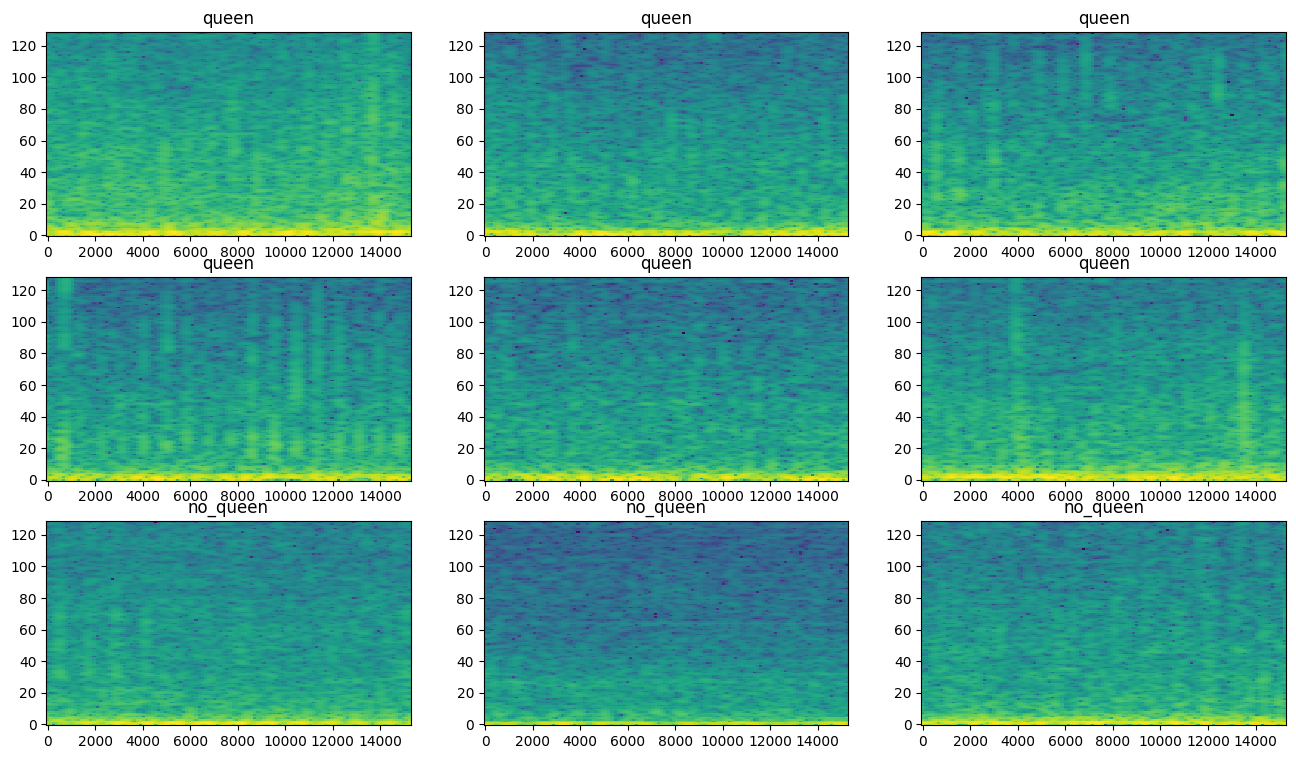

In [8]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

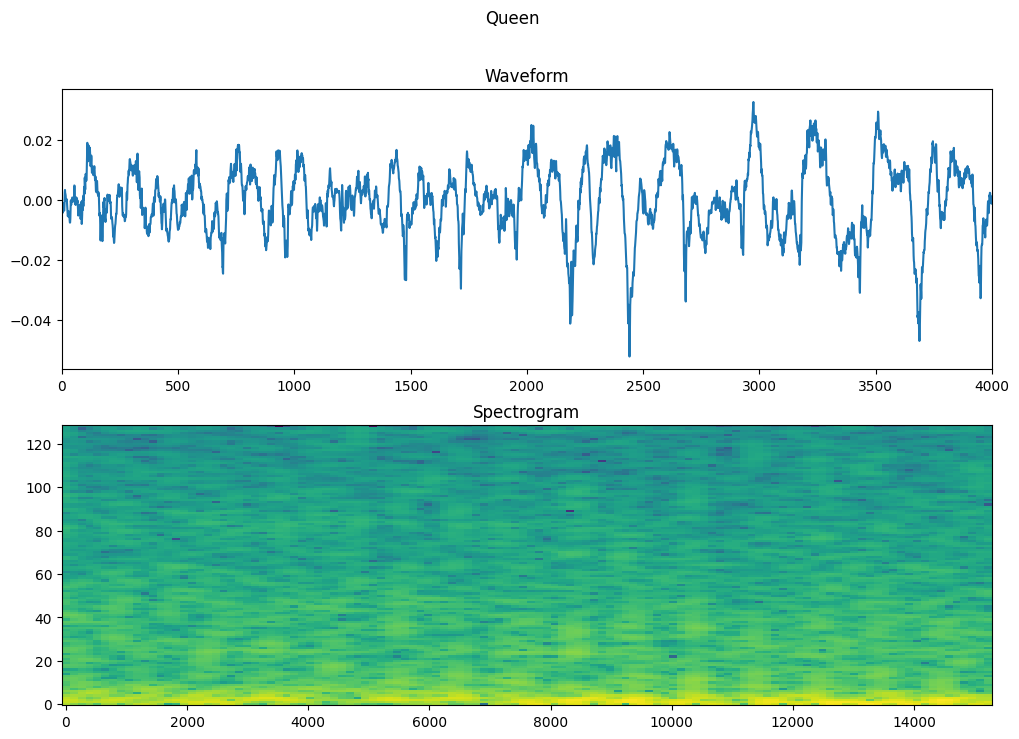

In [9]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 4000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
# test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [14]:
example_spectrograms.shape[1:], len(label_names), train_spectrogram_ds

(TensorShape([118, 129, 1]),
 2,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 118, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [11]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (118, 129, 1)


2024-02-26 22:11:17.764980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
EPOCHS = 60
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/60


2024-02-26 22:11:20.361752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


14/14 [==============================] - 1s 37ms/step - loss: 0.7233 - accuracy: 0.5708 - val_loss: 0.5827 - val_accuracy: 0.8286
Epoch 2/60
14/14 [==============================] - 0s 15ms/step - loss: 0.5937 - accuracy: 0.7288 - val_loss: 0.5352 - val_accuracy: 0.7810
Epoch 3/60
14/14 [==============================] - 0s 14ms/step - loss: 0.5253 - accuracy: 0.7642 - val_loss: 0.4461 - val_accuracy: 0.8571
Epoch 4/60
14/14 [==============================] - 0s 13ms/step - loss: 0.4267 - accuracy: 0.8113 - val_loss: 0.3684 - val_accuracy: 0.8190
Epoch 5/60
14/14 [==============================] - 0s 19ms/step - loss: 0.3632 - accuracy: 0.8325 - val_loss: 0.2837 - val_accuracy: 0.8571
Epoch 6/60
14/14 [==============================] - 0s 16ms/step - loss: 0.3362 - accuracy: 0.8608 - val_loss: 0.2667 - val_accuracy: 0.8952
Epoch 7/60
14/14 [==============================] - 0s 14ms/step - loss: 0.4086 - accuracy: 0.8467 - val_loss: 0.3697 - val_accuracy: 0.8571
Epoch 8/60
14/14 [======

Text(0, 0.5, 'Accuracy [%]')

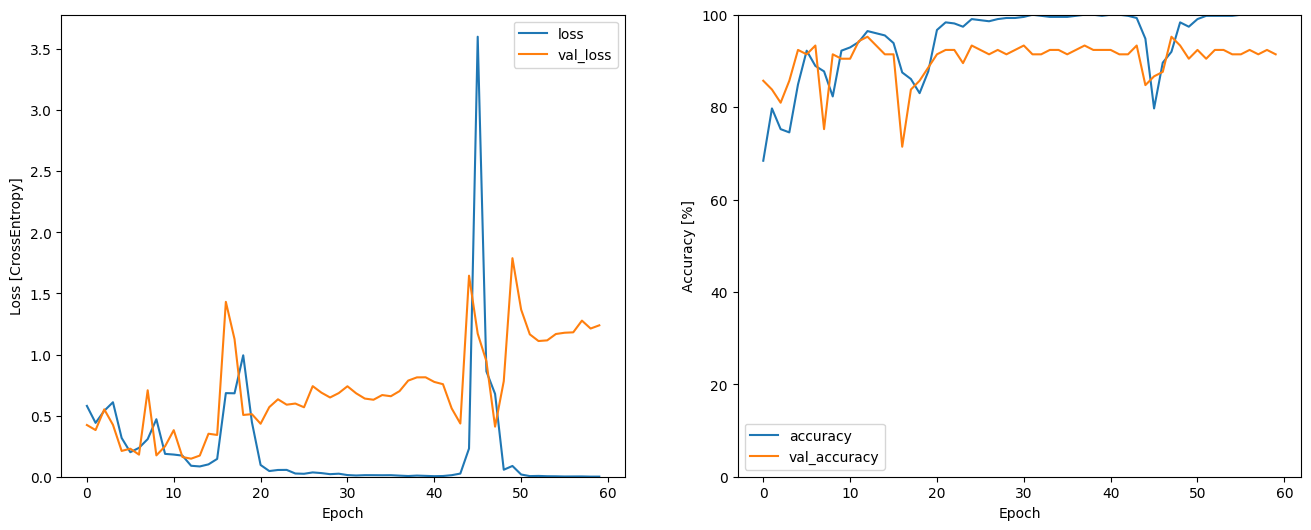

In [68]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [66]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_labels, activation='softmax')(x)
model = Model(input_layer, output_layer)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
history = model.fit(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=EPOCHS)

Epoch 1/60


14/14 [==============================] - 2s 83ms/step - loss: 0.5795 - accuracy: 0.6840 - val_loss: 0.4232 - val_accuracy: 0.8571
Epoch 2/60
14/14 [==============================] - 0s 19ms/step - loss: 0.4406 - accuracy: 0.7972 - val_loss: 0.3818 - val_accuracy: 0.8381
Epoch 3/60
14/14 [==============================] - 0s 18ms/step - loss: 0.5396 - accuracy: 0.7524 - val_loss: 0.5513 - val_accuracy: 0.8095
Epoch 4/60
14/14 [==============================] - 0s 16ms/step - loss: 0.6094 - accuracy: 0.7453 - val_loss: 0.4247 - val_accuracy: 0.8571
Epoch 5/60
14/14 [==============================] - 0s 19ms/step - loss: 0.3173 - accuracy: 0.8491 - val_loss: 0.2110 - val_accuracy: 0.9238
Epoch 6/60
14/14 [==============================] - 0s 17ms/step - loss: 0.2006 - accuracy: 0.9222 - val_loss: 0.2294 - val_accuracy: 0.9143
Epoch 7/60
14/14 [==============================] - 0s 18ms/step - loss: 0.2362 - accuracy: 0.8892 - val_loss: 0.1807 - val_accuracy: 0.9333
Epoch 8/60
14/14 [======